In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 611kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.07MB/s]


In [ ]:

image, label = train_dataset[0]   # Take one image
image = image.unsqueeze(0)  # Add batch dimension

print("Label:", label)

Label: 5


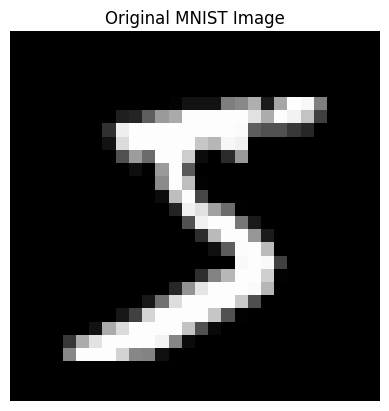

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title("Original MNIST Image")
plt.axis("off")
plt.show()


In [ ]:
# Vertical edge detector
vertical_edge = torch.tensor([
    [[[-1, 0, 1],
      [-1, 0, 1],
      [-1, 0, 1]]]
], dtype=torch.float32)

# Horizontal edge detector
horizontal_edge = torch.tensor([
    [[[-1, -1, -1],
      [ 0,  0,  0],
      [ 1,  1,  1]]]
], dtype=torch.float32)

# Diagonal edge detector
diagonal_edge = torch.tensor([
    [[[ 0,  1,  1],
      [-1,  0,  1],
      [-1, -1,  0]]]
], dtype=torch.float32)


In [ ]:
from torchvision.io import read_image

img = read_image("lena.jpg")  # shape (C, H, W), dtype uint8
img = img.float() / 255.0


In [ ]:
from torchvision.transforms.functional import rgb_to_grayscale

gray = rgb_to_grayscale(img, num_output_channels=1)


In [ ]:
gray.shape

torch.Size([1, 225, 225])

In [ ]:
vertical_features = F.conv2d(gray, vertical_edge, padding=1)
horizontal_features = F.conv2d(gray, horizontal_edge, padding=1)
diagonal_features = F.conv2d(gray, diagonal_edge, padding=1)


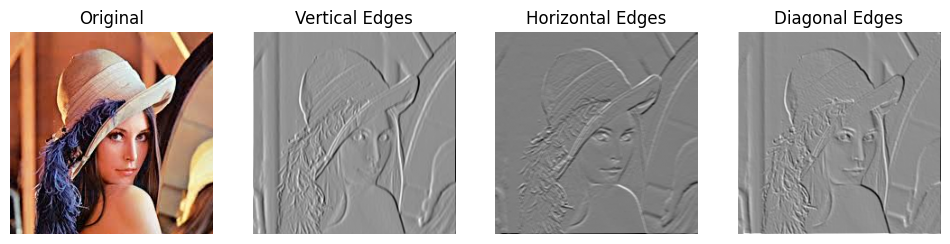

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(image.squeeze(), cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(vertical_features.squeeze(), cmap="gray")
axes[1].set_title("Vertical Edges")
axes[1].axis("off")

axes[2].imshow(horizontal_features.squeeze(), cmap="gray")
axes[2].set_title("Horizontal Edges")
axes[2].axis("off")

axes[3].imshow(diagonal_features.squeeze(), cmap="gray")
axes[3].set_title("Diagonal Edges")
axes[3].axis("off")

plt.show()


In [ ]:
filters = torch.cat([vertical_edge, horizontal_edge, diagonal_edge], dim=0)

features = F.conv2d(gray, filters, padding=1)


In [ ]:
features[0].shape

torch.Size([225, 225])

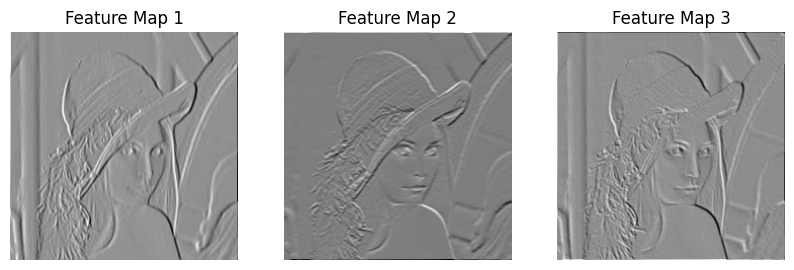

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i in range(3):
    axes[i].imshow(features[i], cmap="gray")
    axes[i].set_title(f"Feature Map {i+1}")
    axes[i].axis("off")

plt.show()


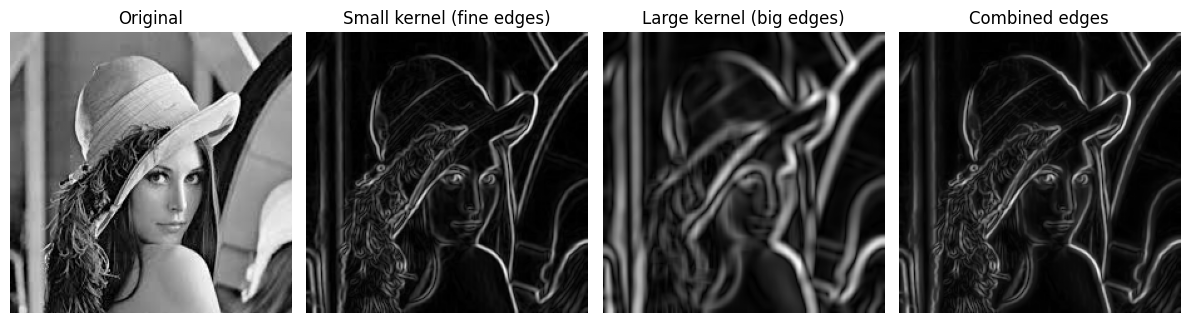

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread("lena.jpg", cv2.IMREAD_GRAYSCALE)

# Normalize
img = img.astype(np.float32) / 255.0

# Small scale edges (fine details)
blur_small = cv2.GaussianBlur(img, (3, 3), sigmaX=1)
gx_s = cv2.Sobel(blur_small, cv2.CV_32F, 1, 0, ksize=3)
gy_s = cv2.Sobel(blur_small, cv2.CV_32F, 0, 1, ksize=3)
edges_small = np.sqrt(gx_s**2 + gy_s**2)

# Large scale edges (big structures)
blur_large = cv2.GaussianBlur(img, (11, 11), sigmaX=4)
gx_l = cv2.Sobel(blur_large, cv2.CV_32F, 1, 0, ksize=3)
gy_l = cv2.Sobel(blur_large, cv2.CV_32F, 0, 1, ksize=3)
edges_large = np.sqrt(gx_l**2 + gy_l**2)

# Combine edges
edges_combined = np.maximum(edges_small, edges_large)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(edges_small, cmap="gray")
plt.title("Small kernel (fine edges)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(edges_large, cmap="gray")
plt.title("Large kernel (big edges)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(edges_combined, cmap="gray")
plt.title("Combined edges")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
model = LeNet().to(device)
print("Total parameters:", count_parameters(model))


Total parameters: 44426


In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_acc = test(model, test_loader)

    print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Test Accuracy = {test_acc:.2f}%")


Epoch 1: Loss = 0.2370, Test Accuracy = 97.86%
Epoch 2: Loss = 0.0680, Test Accuracy = 98.66%
Epoch 3: Loss = 0.0510, Test Accuracy = 98.77%
Epoch 4: Loss = 0.0403, Test Accuracy = 98.94%
Epoch 5: Loss = 0.0315, Test Accuracy = 99.09%


In [ ]:
class VGGSmallMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
vgg_model = VGGSmallMNIST().to(device)
print("VGG MNIST parameters:", count_parameters(vgg_model))


VGG MNIST parameters: 467818


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + identity
        return F.relu(out)


In [ ]:
class ResNetSmallMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        self.block1 = ResidualBlock(32)
        self.block2 = ResidualBlock(32)

        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [ ]:
resnet_model = ResNetSmallMNIST().to(device)
print("ResNet MNIST parameters:", count_parameters(resnet_model))


ResNet MNIST parameters: 100042
